In [1]:
from Optimization.NSGA import MyProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.decomposition.asf import ASF
from pymoo.core.callback import Callback

import numpy as np
import torch
import torch.nn as nn
from TensorProcessing.Dataset import FourWellDataset
from Model.CNN_Transformer import TransformerNN as TransformerNN
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
problem = MyProblem(robust_optimization=True)
pop_size = 350

algorithm = NSGA2(pop_size=pop_size,
                  n_offsprings=200,
                  sampling=FloatRandomSampling(),
                  crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(eta=20),
                  eliminate_duplicates=True)

In [3]:
# history = []
# 
# def record_history(algorithm):
#     global history
#     history.append(algorithm.pop.get("F"))

class MyCallback(Callback):

    def __init__(self, ) -> None:
        super().__init__()
        self.data = {
            'f1_best': [],
            'f2_best': [],
            'history_pts': [],
            'generation': []
        }

    def notify(self, algorithm):
        F = algorithm.pop.get("F")
        
        current_best_obj1 = F[:, 0].min()
        current_best_obj2 = F[:, 1].min()

        self.data['f1_best'].append(current_best_obj1)
        self.data['f2_best'].append(current_best_obj2)

        self.data['history_pts'].append(F.copy())
        self.data['generation'].append(algorithm.n_gen)
        

In [4]:
n_genes = 300

res = minimize(problem,
               algorithm,
               ('n_gen', n_genes),
               callback=MyCallback(),
               seed=777,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      350 |      4 |  0.000000E+00 |  0.1516004617 |             - |             -
     2 |      550 |      4 |  0.000000E+00 |  0.0038022123 |  0.1581915534 |         ideal
     3 |      750 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0456513652 |             f
     4 |      950 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0210053309 |         ideal
     5 |     1150 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1571307211 |         ideal
     6 |     1350 |      6 |  0.000000E+00 |  0.000000E+00 |  0.2076741006 |         ideal
     7 |     1550 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1249540832 |         ideal
     8 |     1750 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0253159675 |         ideal
     9 |     1950 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1965721117 |         ideal
    10 |     2150 |     14 |  0.000000E+00 |  0.000000E+00 |  0.2465116238 |         ideal

In [5]:
X = res.X
F = res.F
np.save(f'X_{X.shape}.npy', X)
np.save(f'F_{F.shape}.npy', F)

# history_points = np.concatenate(history, axis=0)
f1_val = res.algorithm.callback.data['f1_best']
f2_val = res.algorithm.callback.data['f2_best']
history_points = res.algorithm.callback.data['history_pts']

history_points = np.concatenate(history_points, axis=0)
print(history_points.shape)

(105000, 2)


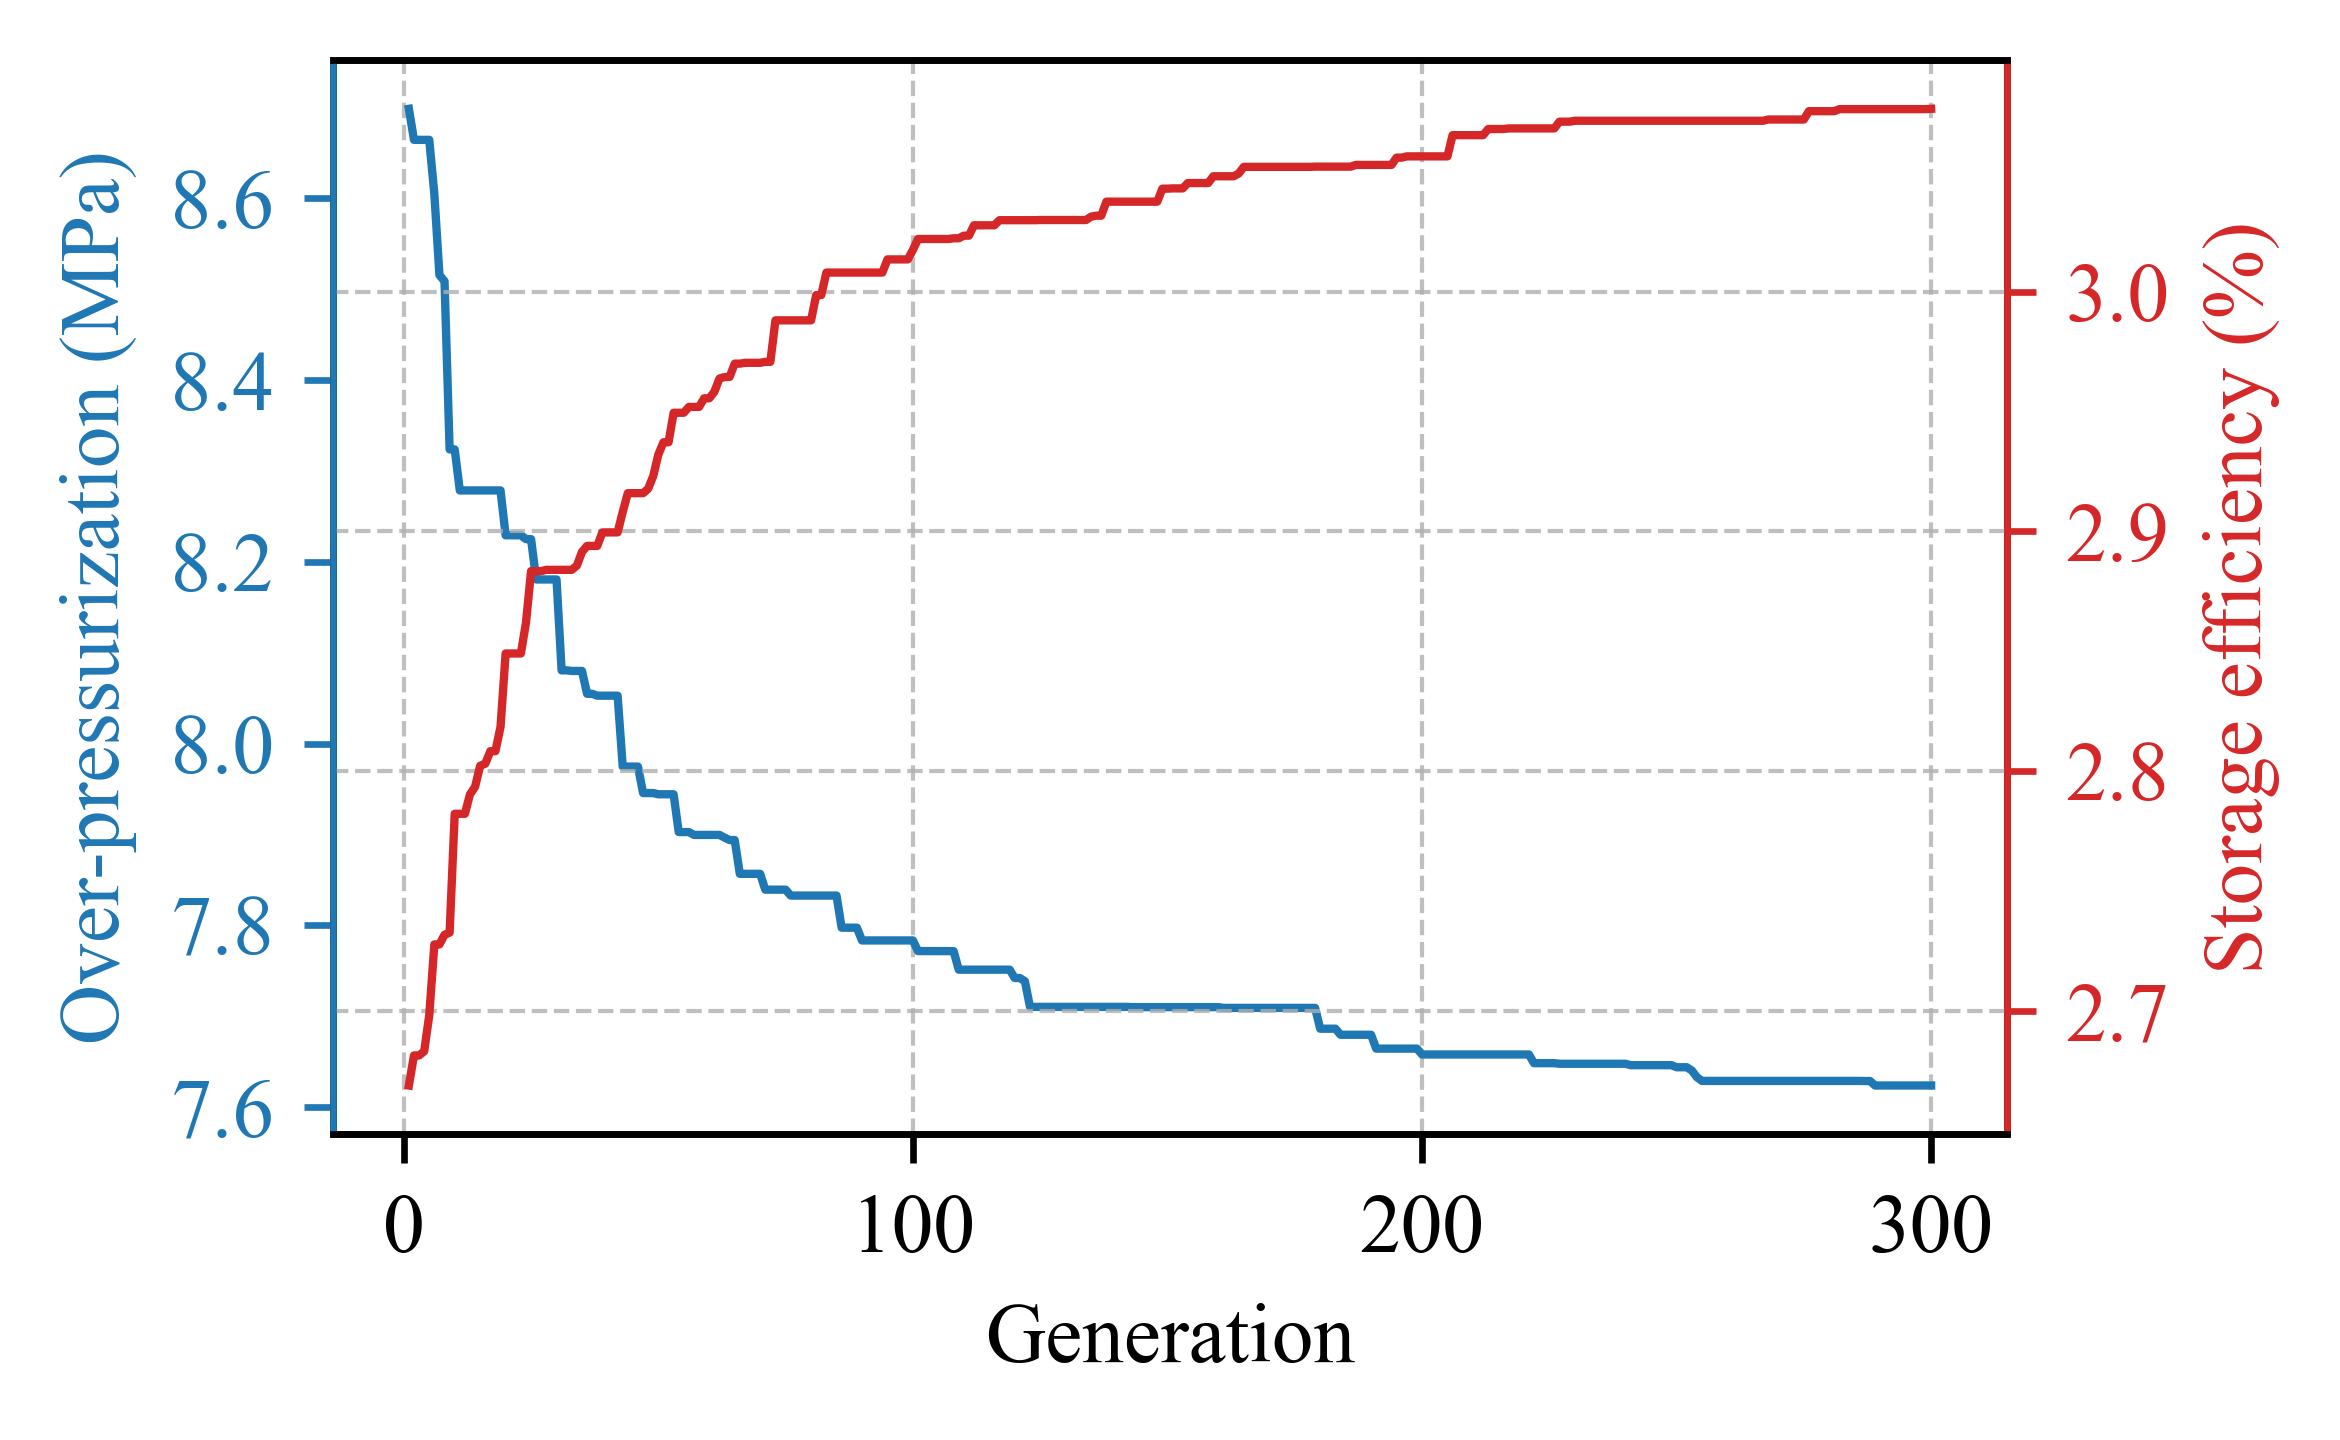

In [6]:
fig, ax1 = plt.subplots(figsize=(4, 2.5), dpi=600)

generations = np.arange(1, n_genes + 1)

color1 = 'tab:blue'
ax1.set_xlabel('Generation')
ax1.set_ylabel('Over-pressurization (MPa)', color=color1)
ax1.plot(generations, f1_val, color=color1, lw=1)
ax1.tick_params(axis='y', labelcolor=color1, colors=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Storage efficiency (%)', color=color2)
ax2.plot(generations, [ss * (-1) for ss in f2_val], color=color2, lw=1)
ax2.tick_params(axis='y', labelcolor=color2, colors=color2)


ax2.spines['right'].set_color(color2)
ax2.spines['left'].set_color(color1)
ax2.yaxis.grid(True, linestyle='--', alpha=0.8, zorder=0, linewidth=0.5)
ax1.xaxis.grid(True, linestyle='--', alpha=0.8, zorder=0, linewidth=0.5)

# plt.xlim(0, n_genes)

fig.tight_layout()
plt.savefig(F'C:\\Users\pc\\Desktop\\CCUS\\tupian\\optimization_curves.tiff', dpi=600, bbox_inches='tight', pad_inches=0.1)

Maximum E idx = 0, Minimum E idx = 1.
Medium E idx = 269


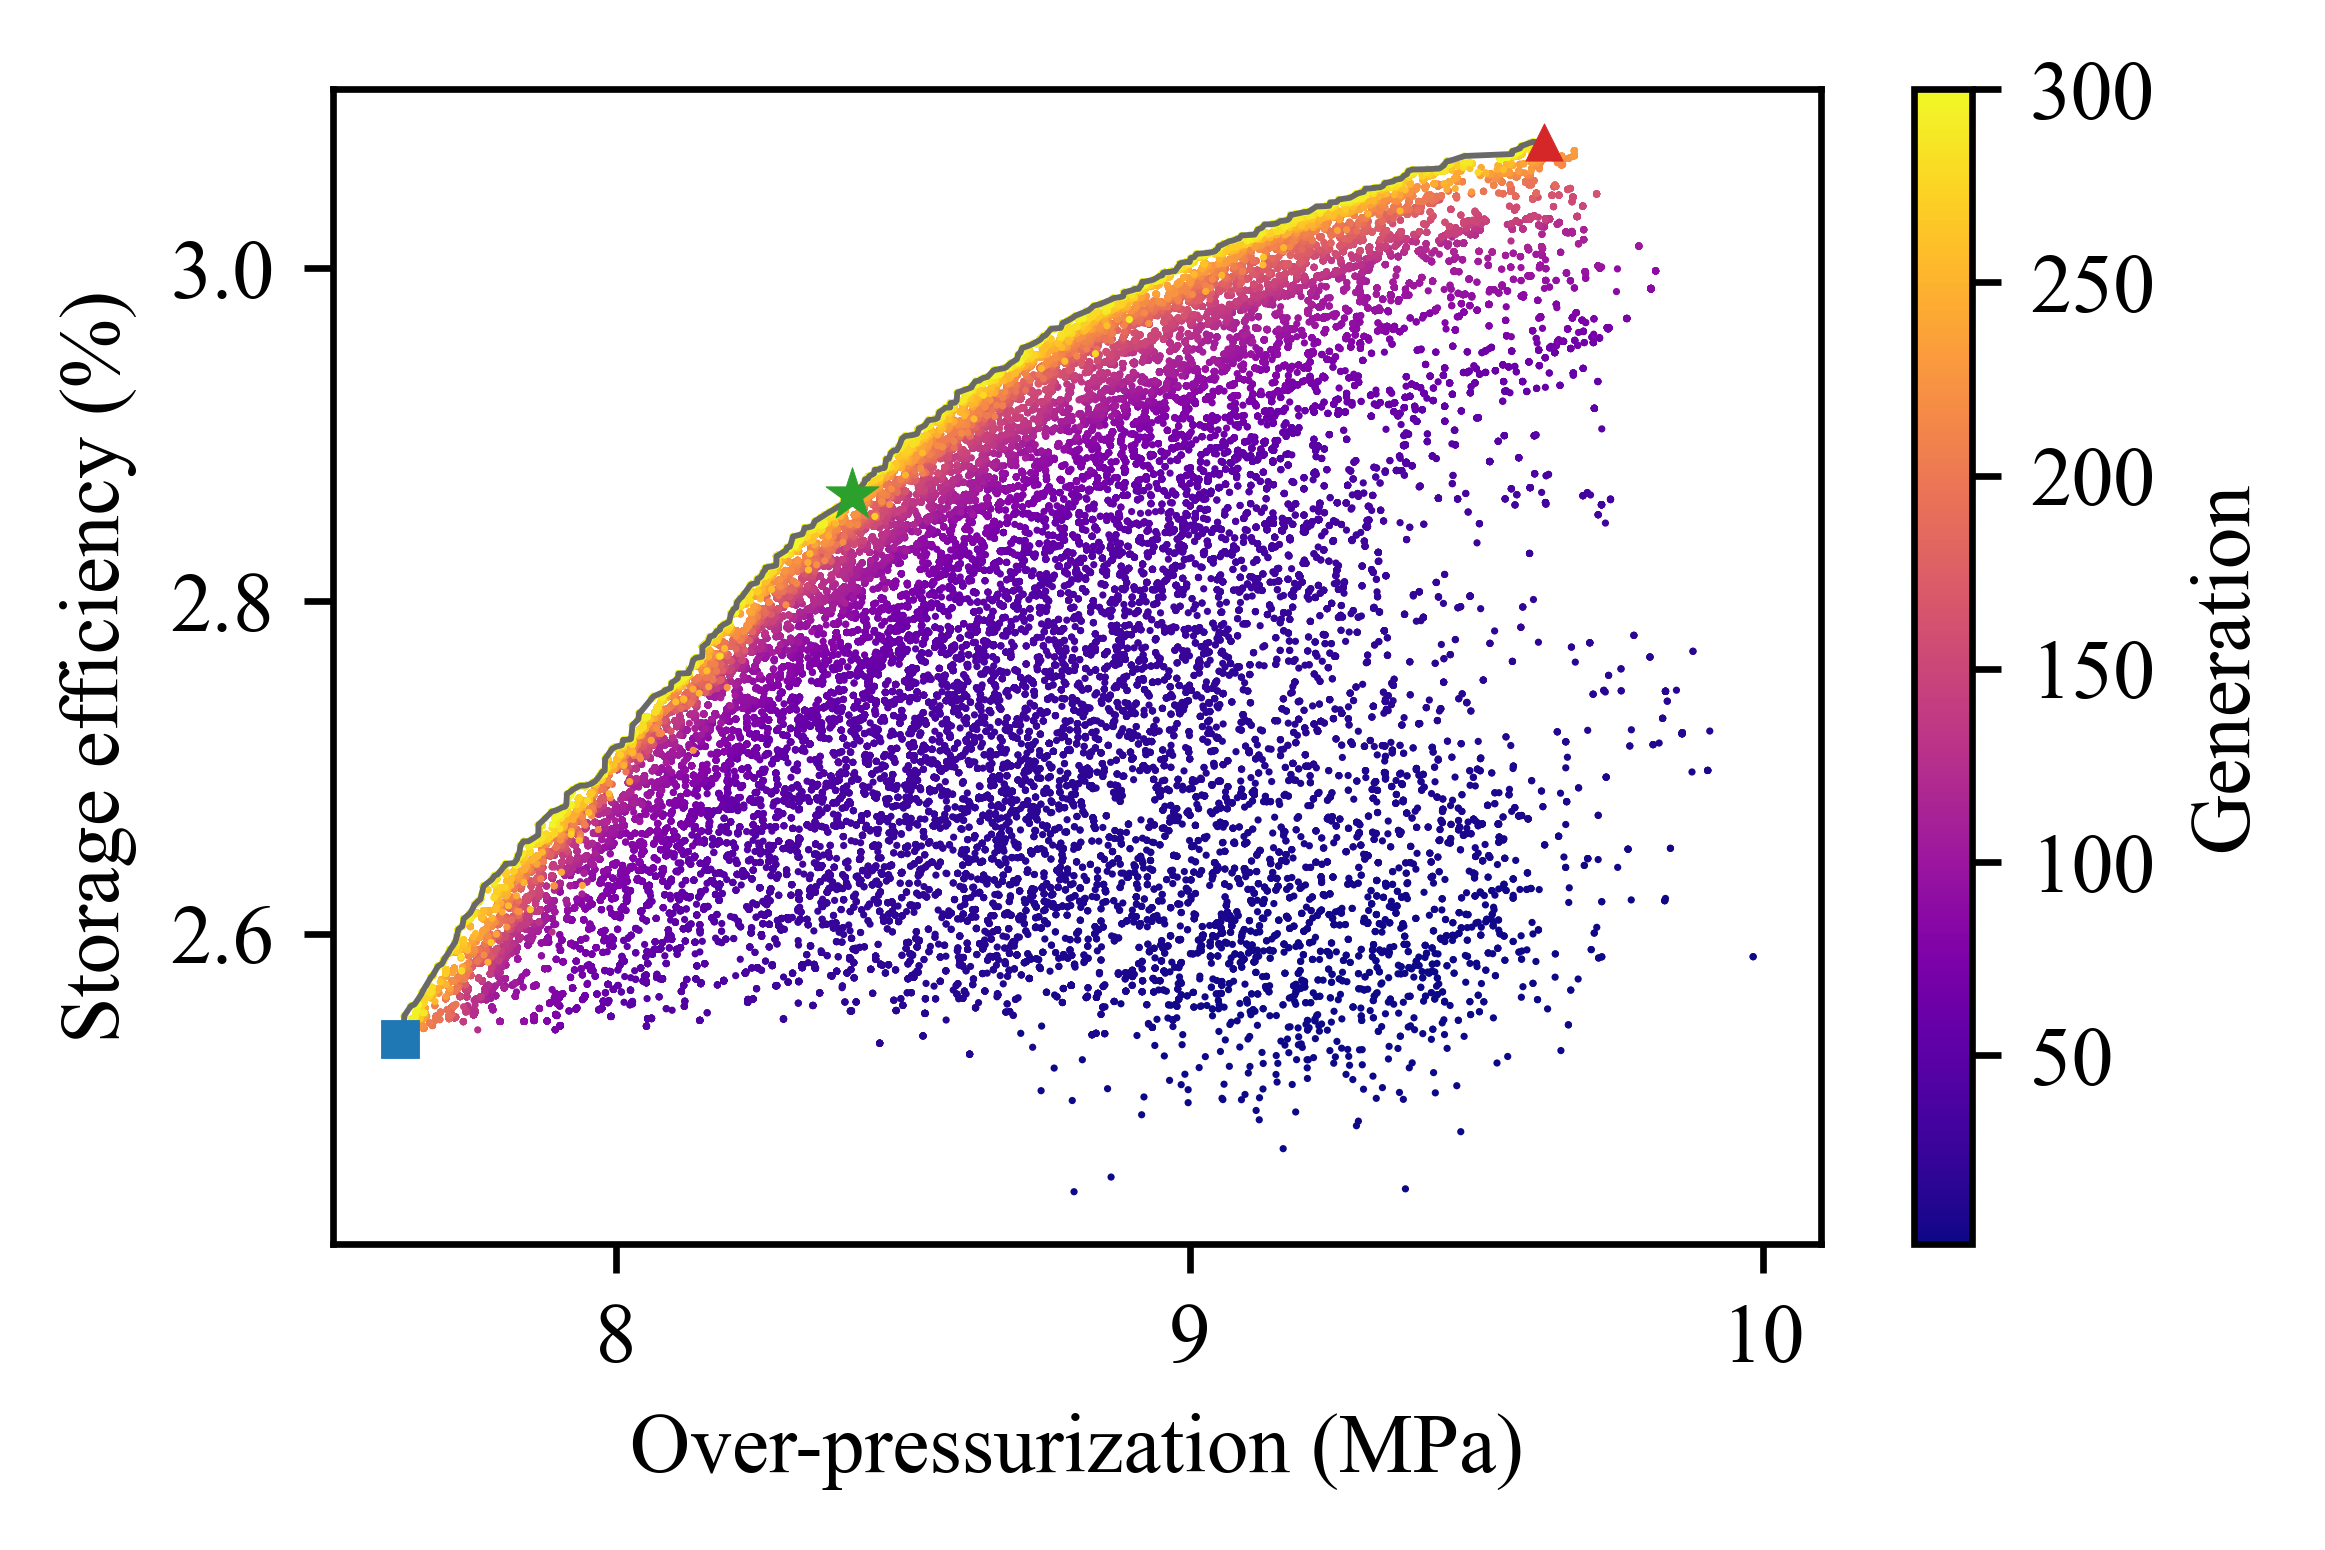

In [7]:
plt.figure(figsize=(4, 2.5), dpi=600)
# plt.grid(True, ls='--', lw=0.5, alpha=0.8, zorder=0)

gene_counts = res.algorithm.callback.data['generation']
generation_counts = np.repeat(np.arange(1, n_genes + 1), pop_size)

sc = plt.scatter(history_points[:, 0], -history_points[:, 1], s=3, c=generation_counts, alpha=1, cmap='plasma', label='History Points', marker='.', linewidths=0.0, zorder=5)
cbar = plt.colorbar(sc)
cbar.set_label('Generation')

sorted_pareto = res.F[np.argsort(res.F[:, 0])]
plt.plot(sorted_pareto[:, 0], -sorted_pareto[:, 1], ls='-', c='dimgray', label='Pareto Front', lw=.7, zorder=5)

efficiency_list = res.F[:, 1] * (-1)
max_efficiency, min_efficiency = np.argmax(efficiency_list), np.argmin(efficiency_list)
print(f'Maximum E idx = {max_efficiency}, Minimum E idx = {min_efficiency}.')
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
fl = nF.min(axis=0)
fu = nF.max(axis=0)
p_weight = 0.5
s_weight = 1 - p_weight
weights = np.array([p_weight, s_weight])
decomp = ASF()
medium_efficiency = decomp.do(nF, 1/weights).argmin()
print(f'Medium E idx = {medium_efficiency}')
plt.scatter(F[max_efficiency, 0], -F[max_efficiency, 1], marker="^", color="tab:red", s=20, edgecolor='tab:red', zorder=5, linewidths=0.1)
plt.scatter(F[min_efficiency, 0], -F[min_efficiency, 1], marker="s", color="tab:blue", s=20, edgecolor='tab:blue', zorder=5, linewidths=0.1)
plt.scatter(F[medium_efficiency, 0], -F[medium_efficiency, 1], marker="*", color="tab:green", s=45, edgecolor='tab:green', zorder=5, linewidths=0.1)



plt.xlabel('Over-pressurization (MPa)')
plt.ylabel('Storage efficiency (%)')

# plt.legend()

plt.savefig(F'C:\\Users\pc\\Desktop\\CCUS\\tupian\\pareto_front.tiff', dpi=600, bbox_inches='tight', pad_inches=0.1)